In [2]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()

In [5]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [6]:
# 死亡是True, 存活是False
# 时间以天为单位
data_y 

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [1]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

NameError: name 'data_y' is not defined

Text(0.5, 0, 'time $t$')

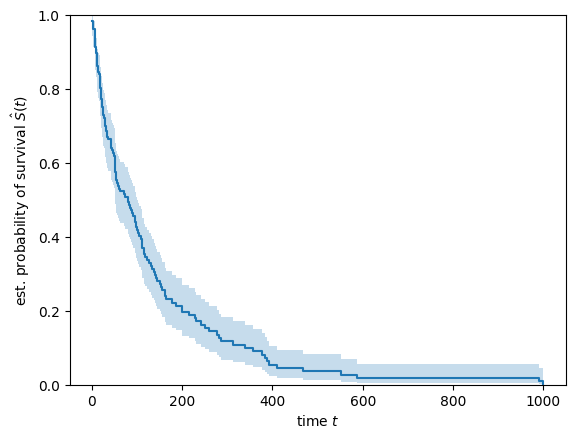

In [4]:
# KM，主要关注分组
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

time, survival_prob, conf_int = kaplan_meier_estimator(data_y['Status'], data_y['Survival_in_days'], conf_type='log-log')

plt.step(time, survival_prob, where='post')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step='post')
plt.ylim(0, 1)
plt.ylabel(r'est. probability of survival $\hat{S}(t)$')
plt.xlabel(r'time $t$')

In [15]:
data_x['Treatment'].value_counts()

Treatment
standard    69
test        68
Name: count, dtype: int64

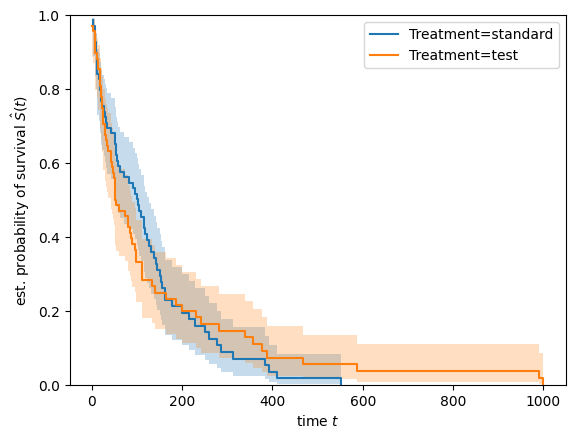

In [7]:
# 分组的生存分析
for treatment_type in ('standard', 'test'):
    mask_treat = data_x['Treatment'] == treatment_type
    time_treatment, survival_prob_treament, conf_int = kaplan_meier_estimator(data_y['Status'][mask_treat], data_y['Survival_in_days'][mask_treat], conf_type='log-log')
    plt.step(time_treatment, survival_prob_treament, where='post', label=f'Treatment={treatment_type}')
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step='post')
plt.ylim(0, 1)
plt.ylabel(r'est. probability of survival $\hat{S}(t)$')
plt.xlabel(r'time $t$')
plt.legend(loc='best')

In [8]:
# Cox风险比例，主要关注变量
## 首先需要将分类变量转换为数值
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0
...,...,...,...,...,...,...,...,...
132,65.0,1.0,0.0,0.0,75.0,1.0,0.0,1.0
133,64.0,1.0,0.0,0.0,60.0,5.0,0.0,1.0
134,67.0,1.0,0.0,0.0,70.0,18.0,1.0,1.0
135,65.0,1.0,0.0,0.0,80.0,4.0,0.0,1.0


In [9]:
# 需要数据矩阵、生存时间和二进制事件指标的结构化数组
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display='text')
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [10]:
# 风险比
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [14]:
## 测量生存模型的性能, c-index
## 0.5表示随机模型，1表示完美模型，0表示完全错误模型
estimator.score(data_x_numeric, data_y)
## 0.736比随机好，但是不完美

np.float64(0.7362562471603816)

In [37]:
# 特征选择，哪个变量最具预测性？
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j: j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

In [40]:
## 排除不相关的特征构建精简模型
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ('encode', OneHotEncoder()),
        ('select', SelectKBest(fit_and_score_features, k=3)),
        ('model', CoxPHSurvivalAnalysis()),
    ]
)

In [42]:
from sklearn.model_selection import GridSearchCV, KFold

# 这里select__k会带入上面SelectKBest中的k
param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1]+1)}
# 3折交叉验证
cv = KFold(n_splits=3, random_state=1, shuffle=True) # 多核
# 尝试所有超参数组合，并使用交叉验证评估每个组合的性能
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
# 执行拟合
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith('_time')]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


In [44]:
## 上面结果表明5个特征就已经足够
## 使用最佳参数
pipe.set_params(**gcv.best_params_)
## 使用最佳参数重新拟合
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = (s[1] for s in pipe.steps)
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64

In [46]:
# Penalied Cox模型
## 如果想估计许多特征的系数，标准Cox模型就会崩溃，因为它在内部试图翻转由于特征之间的相关性而变得非奇异的矩阵
## 通过在系数上添加罚分项避免
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

set_config(display='text')

In [73]:
# 乳腺癌数据
## 包含76个基因表达水平
X, y = load_breast_cancer() 
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()
Xt

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,9.623518,9.814798,10.016732,7.847383,...,10.132635,10.926365,6.477749,5.991885,57.0,0.0,0.0,1.0,0.0,3.0
1,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,10.604577,10.704329,10.161838,8.744875,...,10.213467,9.555092,4.968050,7.051130,57.0,1.0,0.0,1.0,0.0,3.0
2,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,9.384927,10.161654,10.032721,8.125487,...,10.164514,9.308048,4.283777,6.828986,48.0,0.0,0.0,1.0,0.0,2.5
3,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,8.400839,8.670721,10.727427,8.650810,...,10.660092,10.208241,5.713404,6.927251,42.0,1.0,0.0,1.0,0.0,1.8
4,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,7.741092,8.642018,9.556686,8.478862,...,11.570330,10.931843,5.817265,6.655448,46.0,1.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,12.018292,8.323876,11.955274,10.740020,11.150428,10.650873,8.787549,9.747182,10.176306,9.240307,...,10.074577,9.604668,6.889179,5.892040,39.0,0.0,0.0,1.0,0.0,2.2
194,11.711415,10.428482,12.420877,11.145993,11.084685,11.169750,10.870530,11.128882,9.573702,9.287522,...,11.289674,11.067820,5.393927,6.421038,46.0,0.0,0.0,1.0,0.0,3.2
195,11.939616,9.615587,11.962812,10.463171,11.514539,11.487394,10.443569,11.104227,9.051649,7.279063,...,11.490971,7.743568,5.922925,6.979894,47.0,1.0,0.0,0.0,0.0,2.5
196,11.848449,10.528911,11.318453,8.609631,13.719035,12.909814,7.525994,8.255546,9.788903,7.343499,...,11.092211,9.298178,7.278383,7.195797,43.0,1.0,1.0,0.0,0.0,1.2


In [74]:
y

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

In [97]:
## 拟合罚分cox模型到多个alpha值，并记录每个alpha值计算到的系数
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_
coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index='feature', columns='alpha').set_index(Xt.columns)
print(coefficients.iloc[:, :5].head())

alpha          0.00010   0.00015   0.00021   0.00031   0.00045
X200726_at   -4.013836 -4.004698 -3.991541 -3.972654 -3.945662
X200965_s_at  0.700191  0.699126  0.697611  0.695464  0.692437
X201068_s_at -3.825737 -3.818358 -3.807744 -3.792528 -3.770828
X201091_s_at -2.747885 -2.745670 -2.742429 -2.737696 -2.730805
X201288_at    0.799201  0.797567  0.795212  0.791829  0.786989


In [104]:
def plot_coefficents(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)
    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "    ", horizontalalignment='right', verticalalignment='center')
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel('alpha')
    ax.set_ylabel('coefficient')

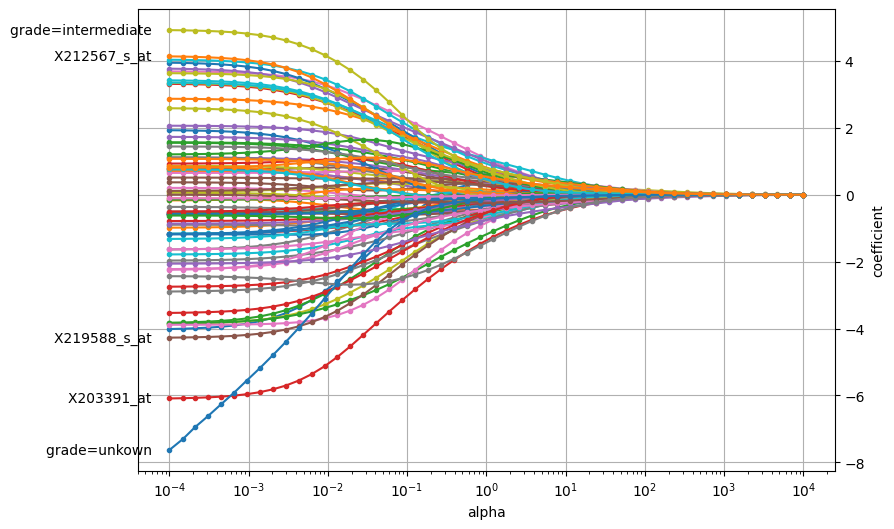

In [105]:
plot_coefficents(coefficients, n_highlight=5)
## alpha值增大，所有系数几乎收缩到0。alpha值减小，系数值增加。
## 看到X203391_at和grade很快与其他系数分开，表明这种特定的基因表达水平和grade是远端转移时间的重要预测因素

In [106]:
# LASSO
## 虽然罚分cox解决了拟合cox模型的数学问题，但是我们仍然需要测量所有76个基因的表达水平才能做出预测
## 理想情况下，我们想选择一小部分最具预测性的特征，并忽略其余的基因表达水平。
## 这正是LASSO罚分的作用。它不是将系数收缩到0，而是执行一种连续子集选择，其中系数子集设置为0并被有效排除。这减少了我们需要记录以进行预测的特征数量

## 我们不能直接控制被选择特征数量。但是可以以一个数据驱动的方式选择一个合适的alpha值并获得一个简约模型
## 可以先计算可以忽略所有特征的alpha值，然后逐渐减少，直到到达原始alpha值的1%
### l1_ration=1, 使用LASSO。alpha_min_ration=0.01搜索100个alpha值，最高可到估计最大值的1%
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1)

In [108]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))
coefficients_lasso

,0.20776,0.19832,0.18931,0.18070,0.17249,0.16465,0.15717,0.15002,0.14320,0.13670,...,0.00316,0.00301,0.00288,0.00275,0.00262,0.00250,0.00239,0.00228,0.00218,0.00208
X200726_at,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024054,0.027325,0.028021,0.028339,0.027642,0.030145,0.033526,0.035669,0.037294,0.037416
X200965_s_at,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133338,0.138082,0.143405,0.147776,0.151766,0.153400,0.153521,0.153784,0.155406,0.156785
X201068_s_at,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.435139,-0.465118,-0.496125,-0.527819,-0.559967,-0.596237,-0.635556,-0.674830,-0.711508,-0.749713
X201091_s_at,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.427901,-0.457214,-0.487692,-0.516664,-0.544706,-0.573766,-0.603120,-0.631965,-0.660053,-0.688206
X201288_at,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
er=positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.195477,-2.224702,-2.256235,-2.286883,-2.317660,-2.345504,-2.371602,-2.398665,-2.426724,-2.455407
grade=intermediate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.505253,0.560385,0.616753,0.672344,0.727845,0.787674,0.850345,0.912616,0.970203,1.029673
grade=poorly differentiated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030030,0.079132,0.128807,0.177375,0.225418,0.273179,0.320928,0.368847,0.417515,0.466673
grade=unkown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


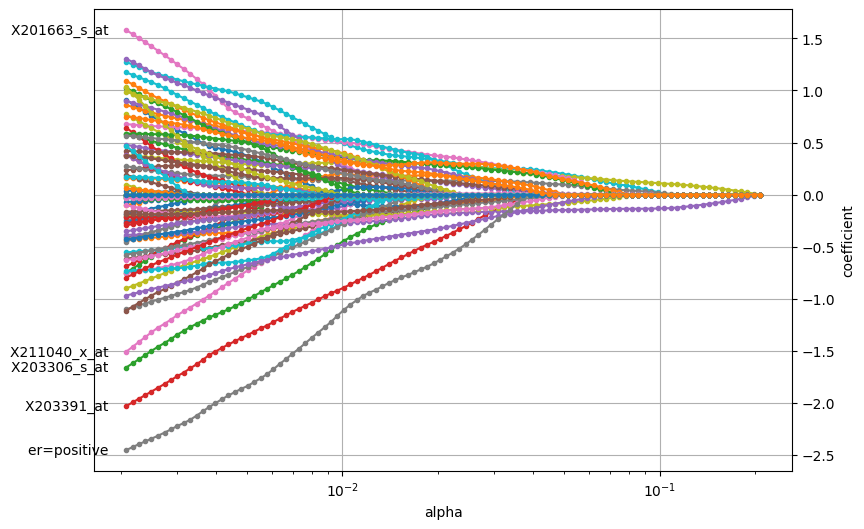

In [109]:
plot_coefficents(coefficients_lasso, n_highlight=5)
## 该图显示，LASSO惩罚确实为大alpha（右侧）选择了一小部分特征，只有与两个特征（紫色和黄色）不为零。
## 随着alpha的减少，越来越多的特征便成为活跃状态并被分配非零系数，直到使用整个特征集（最左）。
## 与罚分cox图相似，X203391_at的路径非常突出，表明它在乳腺癌中的重要性。然而，总体上最重要的因素似乎是雌激素受体状态（er）阳性